# 3D Reconstruction from an Uncalibrated Stereo Pair

This notebook demonstrates sparse 3D reconstruction from an **uncalibrated** stereo pair:

1. Load the left/right images.
2. Detect and match features using ORB.
3. Estimate the fundamental matrix with RANSAC.
4. Recover a projective camera pair from the fundamental matrix.
5. Triangulate 3D points and visualize the point cloud.

**Note**: Because the stereo is *uncalibrated*, the reconstruction is only defined up to a projective transformation (you cannot directly read metric distances).


## Imports & configuration

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D visualization
import os

print("OpenCV version:", cv2.__version__)
%matplotlib inline

OpenCV version: 4.12.0


## Paths & basic parameters

In [ ]:
# TODO: set these to your actual image paths
LEFT_IMAGE_PATH = "./images/hand_left.jpg"
RIGHT_IMAGE_PATH = "./images/hand_right.jpg" 

# Number of best matches to keep before RANSAC
MAX_MATCHES = 2000

# RANSAC parameters for fundamental matrix
RANSAC_REPROJ_THRESH = 1.0  # reprojection threshold in pixels
RANSAC_CONFIDENCE = 0.99

# sanity check
assert os.path.exists(LEFT_IMAGE_PATH), f"Left image not found: {LEFT_IMAGE_PATH}"
assert os.path.exists(RIGHT_IMAGE_PATH), f"Right image not found: {RIGHT_IMAGE_PATH}"


## Load and show the stereo pair

Left image shape: (4624, 2608, 3)
Right image shape: (4624, 2608, 3)


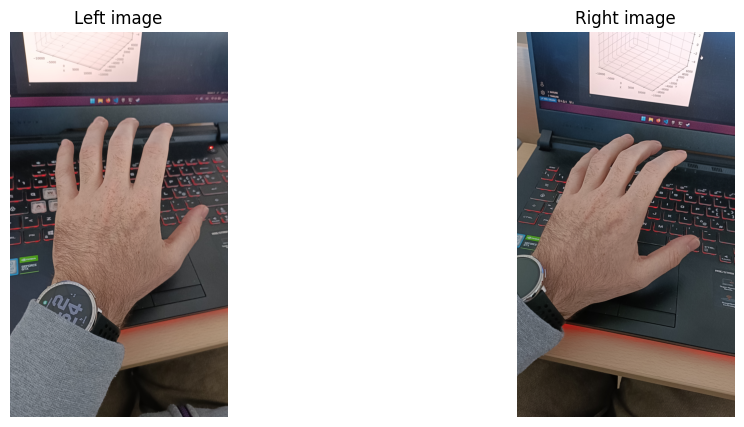

In [ ]:
# Load images (color)
img_left_color = cv2.imread(LEFT_IMAGE_PATH, cv2.IMREAD_COLOR)
img_right_color = cv2.imread(RIGHT_IMAGE_PATH, cv2.IMREAD_COLOR)

if img_left_color is None or img_right_color is None:
    raise RuntimeError("Failed to load one or both images. Check paths and formats.")

# Convert BGR (OpenCV) to RGB (matplotlib)
img_left = cv2.cvtColor(img_left_color, cv2.COLOR_BGR2RGB)
img_right = cv2.cvtColor(img_right_color, cv2.COLOR_BGR2RGB)

# Convert to grayscale for feature detection
gray_left = cv2.cvtColor(img_left, cv2.COLOR_RGB2GRAY)
gray_right = cv2.cvtColor(img_right, cv2.COLOR_RGB2GRAY)

print("Left image shape:", img_left.shape)
print("Right image shape:", img_right.shape)

# Display stereo pair
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Left image")
plt.imshow(img_left)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Right image")
plt.imshow(img_right)
plt.axis("off")

plt.show()


## Feature detection & matching (ORB + BFMatcher)

Detected 5000 keypoints in left image.
Detected 5000 keypoints in right image.
Total raw matches: 632
Using 632 best matches for fundamental matrix estimation.


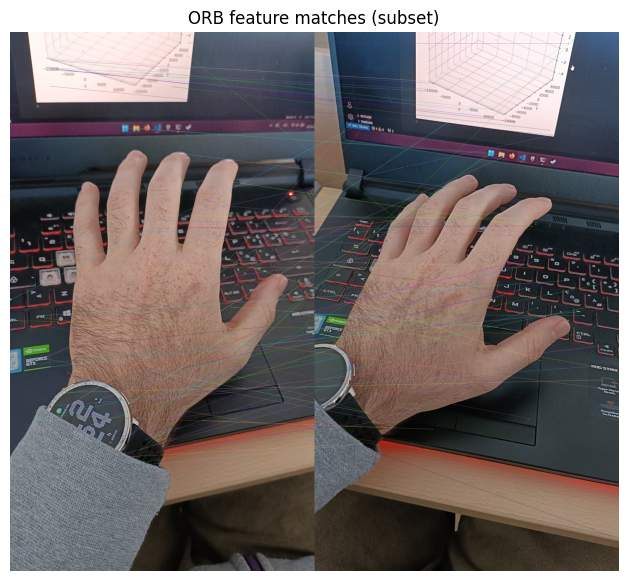

In [ ]:
# Initialize ORB detector
orb = cv2.ORB_create(nfeatures=5000)

# Detect keypoints and compute descriptors
kp1, des1 = orb.detectAndCompute(gray_left, None)
kp2, des2 = orb.detectAndCompute(gray_right, None)

# Initialize SIFT detector
sift = cv2.SIFT_create(nfeatures=5000)

# Detect keypoints and compute descriptors
kp1, des1 = sift.detectAndCompute(gray_left, None)
kp2, des2 = sift.detectAndCompute(gray_right, None)

print(f"Detected {len(kp1)} keypoints in left image.")
print(f"Detected {len(kp2)} keypoints in right image.")

if des1 is None or des2 is None:
    raise RuntimeError("Descriptors are None. Try different images or a different feature extractor.")

# Brute-force matcher with Hamming distance (for ORB)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Brute-force matcher with L1 distance (for SIFT)
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
matches = bf.match(des1, des2)

print(f"Total raw matches: {len(matches)}")

# Sort matches by descriptor distance
matches = sorted(matches, key=lambda x: x.distance)

# Keep only the best matches
good_matches = matches[:min(MAX_MATCHES, len(matches))]
print(f"Using {len(good_matches)} best matches for fundamental matrix estimation.")

# Visualize a subset of matches
matches_to_show = min(100, len(good_matches))
img_matches = cv2.drawMatches(
    img_left, kp1,
    img_right, kp2,
    good_matches[:matches_to_show],
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(15,7))
plt.title("ORB feature matches (subset)")
plt.imshow(img_matches)
plt.axis("off")
plt.show()


## Prepare matched points & estimate fundamental matrix (RANSAC)

pts1 shape: (632, 2)
pts2 shape: (632, 2)
Estimated fundamental matrix F:
 [[-1.09313514e-07  2.97032322e-07 -5.95510455e-04]
 [-3.90454354e-07  2.01527252e-07 -2.32292046e-04]
 [ 8.25542781e-04 -6.56899450e-04  1.00000000e+00]]
Inliers after RANSAC: 18 / 632


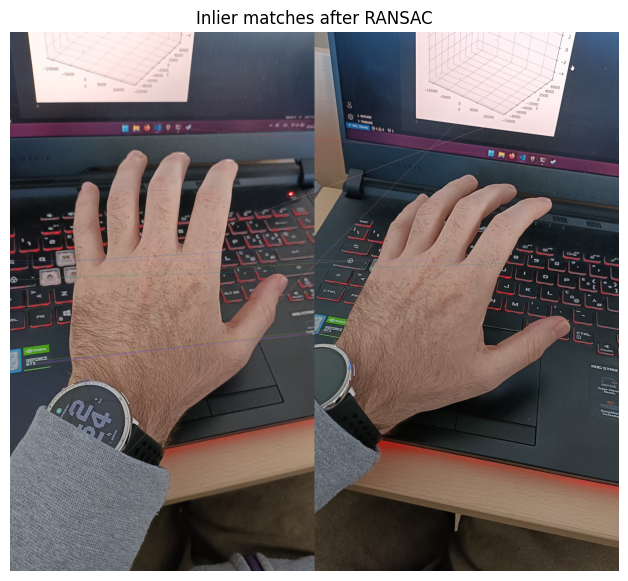

In [ ]:
# Extract matched keypoint coordinates
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

print("pts1 shape:", pts1.shape)
print("pts2 shape:", pts2.shape)

# Estimate fundamental matrix using RANSAC
F, mask = cv2.findFundamentalMat(
    pts1, pts2,
    method=cv2.FM_RANSAC,
    ransacReprojThreshold=RANSAC_REPROJ_THRESH,
    confidence=RANSAC_CONFIDENCE
)

if F is None:
    raise RuntimeError("Fundamental matrix estimation failed. Try different images or parameters.")

inlier_mask = mask.ravel().astype(bool)
inliers1 = pts1[inlier_mask]
inliers2 = pts2[inlier_mask]

print("Estimated fundamental matrix F:\n", F)
print(f"Inliers after RANSAC: {inliers1.shape[0]} / {pts1.shape[0]}")

# Visualize inlier matches
inlier_matches = [gm for gm, keep in zip(good_matches, inlier_mask) if keep]
matches_to_show = min(80, len(inlier_matches))
img_inlier_matches = cv2.drawMatches(
    img_left, kp1,
    img_right, kp2,
    inlier_matches[:matches_to_show],
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(15,7))
plt.title("Inlier matches after RANSAC")
plt.imshow(img_inlier_matches)
plt.axis("off")
plt.show()


## (Optional) Visual check of epipolar geometry

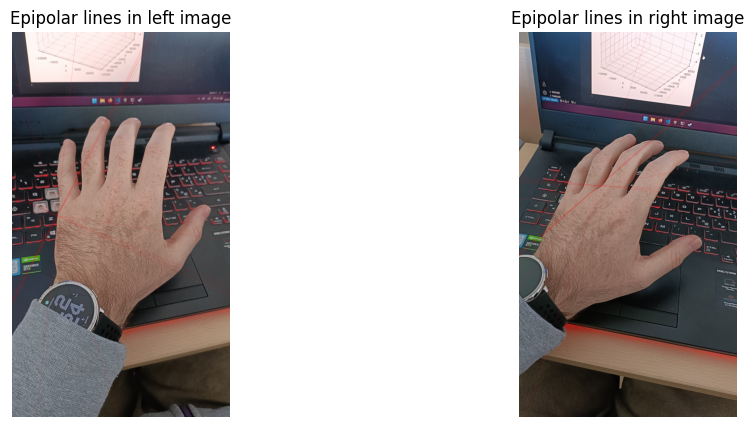

In [ ]:
def draw_epipolar_lines(F, img1, img2, pts1, pts2, num_samples=30):
    """
    Draw epipolar lines in img2 corresponding to points in img1 and vice versa.
    F: fundamental matrix (3x3)
    img1, img2: RGB images
    pts1, pts2: Nx2 arrays of corresponding points (inliers)
    """
    # Random subset of inliers
    if pts1.shape[0] > num_samples:
        idx = np.random.choice(pts1.shape[0], num_samples, replace=False)
        pts1 = pts1[idx]
        pts2 = pts2[idx]

    # Convert to homogeneous coordinates
    pts1_h = np.hstack([pts1, np.ones((pts1.shape[0], 1))])
    pts2_h = np.hstack([pts2, np.ones((pts2.shape[0], 1))])

    # Lines in second image corresponding to pts1
    lines2 = (F @ pts1_h.T).T   # each row: a, b, c for line ax + by + c = 0
    # Lines in first image corresponding to pts2
    lines1 = (F.T @ pts2_h.T).T

    def draw_lines(img, lines, pts):
        h, w = img.shape[:2]
        img_color = img.copy()
        for r, pt in zip(lines, pts):
            a, b, c = r
            # line endpoints: x=0 and x=w-1
            x0, y0 = 0, int(-c / b) if b != 0 else 0
            x1, y1 = w - 1, int((-c - a * (w - 1)) / b) if b != 0 else h - 1
            img_color = cv2.line(img_color, (x0, y0), (x1, y1), (255, 0, 0), 1)
            img_color = cv2.circle(img_color, tuple(np.int32(pt)), 4, (0, 255, 0), -1)
        return img_color

    img1_lines = draw_lines(img1.copy(), lines1, pts1)
    img2_lines = draw_lines(img2.copy(), lines2, pts2)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.title("Epipolar lines in left image")
    plt.imshow(img1_lines)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Epipolar lines in right image")
    plt.imshow(img2_lines)
    plt.axis("off")
    plt.show()

draw_epipolar_lines(F, img_left, img_right, inliers1, inliers2, num_samples=25)


## Build a projective camera pair from the fundamental matrix

We’ll construct canonical camera matrices: $\mathrm{P} = [ \mathrm{I} | \mathbf{0}]$ and $\mathrm{P}' = [ [\mathbf{e'}]_{\times} \mathrm{F} | \mathbf{e}']$


In [ ]:
def skew(x):
    """
    Return the skew-symmetric matrix [x]_x such that [x]_x * y = x x y (cross product).
    x: 3-element array-like
    """
    x = x.ravel()
    return np.array([
        [0,      -x[2],  x[1]],
        [x[2],   0,     -x[0]],
        [-x[1],  x[0],   0   ]
    ], dtype=np.float64)

# SVD of F
U, S, Vt = np.linalg.svd(F)

# Epipole in the second image (left nullspace of F)
e_prime = U[:, -1]
e_prime = e_prime / e_prime[2]

print("Epipole in second image e':", e_prime)

# Camera 1: P1 = [I | 0]
P1 = np.hstack([np.eye(3), np.zeros((3, 1))])

# Camera 2: P2 = [[e']_x F | e']
e_x = skew(e_prime)
P2 = np.hstack([e_x @ F, e_prime.reshape(3, 1)])

print("P1:\n", P1)
print("P2:\n", P2)


Epipole in second image e': [9.59253702e+02 1.84575580e+03 1.00000000e+00]
P1:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
P2:
 [[ 1.52375077e+00 -1.21247617e+00  1.84575603e+03  9.59253702e+02]
 [-7.91905079e-01  6.30133526e-01 -9.59254298e+02  1.84575580e+03]
 [-1.72778732e-04 -3.54933370e-04  8.76339871e-01  1.00000000e+00]]


## Triangulate 3D points

In [ ]:
# Prepare points for triangulation: shape (2, N)
pts1_t = inliers1.T  # (2, N)
pts2_t = inliers2.T  # (2, N)

# cv2.triangulatePoints expects float64 or float32
P1_float = P1.astype(np.float64)
P2_float = P2.astype(np.float64)
pts1_t = pts1_t.astype(np.float64)
pts2_t = pts2_t.astype(np.float64)

# Triangulate
points4D_h = cv2.triangulatePoints(P1_float, P2_float, pts1_t, pts2_t)  # 4 x N

# Convert from homogeneous to Euclidean coordinates
points3D = points4D_h[:3, :] / points4D_h[3, :]
points3D = points3D.T  # N x 3

print("Triangulated 3D points shape:", points3D.shape)

# For nicer visualization, center the point cloud
mean_3d = np.mean(points3D, axis=0)
points3D_centered = points3D - mean_3d


Triangulated 3D points shape: (18, 3)


## Visualize the 3D point cloud

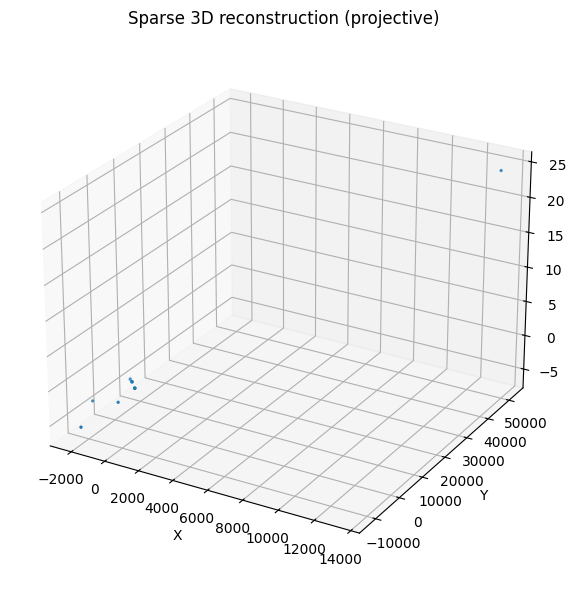

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    points3D_centered[:, 0],
    points3D_centered[:, 1],
    points3D_centered[:, 2],
    s=2
)

ax.set_title("Sparse 3D reconstruction (projective)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# Adjust viewing angle if desired
ax.view_init(elev=25, azim=-60)

plt.tight_layout()
plt.show()
